# Quantum Kernel & Quantum Support Vector Machine - Lab part

In [1]:
from qiskit_machine_learning.utils import algorithm_globals
from qiskit_machine_learning.datasets import ad_hoc_data
import matplotlib.pyplot as plt
import numpy as np
from qiskit.circuit.library import (
    ZZFeatureMap,
    ZFeatureMap,
    RealAmplitudes,
)
from qiskit.primitives import StatevectorSampler as Sampler
from qiskit_machine_learning.state_fidelities import ComputeUncompute
from qiskit_machine_learning.kernels import FidelityQuantumKernel
from sklearn.svm import SVC
from qiskit_machine_learning.algorithms import QSVC


algorithm_globals.random_seed = 12345

This code utilizes Qiskit Machine Learning to generate a synthetic dataset and set the random seed to ensure reproducibility in experiments.

First, `algorithm_globals` is imported from `qiskit_machine_learning.utils`, allowing the configuration of global parameters for running quantum machine learning algorithms. The random seed is then set to `12345` using `algorithm_globals.random_seed = 12345`. This is essential for ensuring consistent results across multiple runs, controlling the generation of random numbers in quantum models, and facilitating debugging.

Next, the function `ad_hoc_data` is imported from the `qiskit_machine_learning.datasets` module. This function generates a synthetic dataset specifically designed to evaluate quantum classification algorithms. The variable `adhoc_dimension = 2` is defined, indicating that the data will be in a two-dimensional feature space.

Then, `ad_hoc_data()` is called with the following parameters:
- `training_size=20`: Generates 20 training samples.
- `test_size=5`: Generates 5 test samples.
- `n=adhoc_dimension`: Sets the problem dimension to 2.
- `gap=0.3`: Defines the separation between classes to improve separability.
- `plot_data=False`: Avoids plotting the dataset.
- `one_hot=False`: Returns labels in ordinal format (0 and 1) instead of one-hot encoding.
- `include_sample_total=True`: Returns the total number of generated samples.

This code returns five variables:
- `train_features`: Feature set for training.
- `train_labels`: Training labels.
- `test_features`: Feature set for testing.
- `test_labels`: Testing labels.
- `adhoc_total`: Total number of generated samples.


In [2]:

adhoc_dimension = 2
train_features, train_labels, test_features, test_labels, adhoc_total = ad_hoc_data(
    training_size=20,
    test_size=5,
    n=adhoc_dimension,
    gap=0.3,
    plot_data=False,
    one_hot=False,
    include_sample_total=True,
)

This code defines functions to visualize a synthetic dataset using `matplotlib`. It plots both training and testing data points, differentiating between two classes using distinct markers and colors.

First, the required libraries are imported: `matplotlib.pyplot` for visualization and `numpy` for numerical operations.

The `plot_features` function is defined to plot data points of a specific class within the given dataset. It takes parameters for the plotting axis, feature set, labels, class label (0 or 1), marker style, face color, edge color, and legend label. The function filters the dataset to select points corresponding to the specified class and then uses `ax.scatter()` to plot them.

The `plot_dataset` function is responsible for the overall visualization of the dataset, including both training and testing samples. It first sets up the figure size (`5x5`) and defines axis limits from `0` to `2π`. Then, it plots a background decision surface (`adhoc_total`) using `plt.imshow()`, applying the `RdBu` colormap. 

The function calls `plot_features` multiple times to plot:
- **Class A (label 0)**: 
  - Training samples as white squares with blue edges.
  - Testing samples as blue squares with white edges.
- **Class B (label 1)**:
  - Training samples as white circles with red edges.
  - Testing samples as red circles with white edges.

Finally, the function adds a legend positioned outside the main plot and sets the title to *"Ad hoc dataset"*. It then calls `plt.show()` to display the visualization.


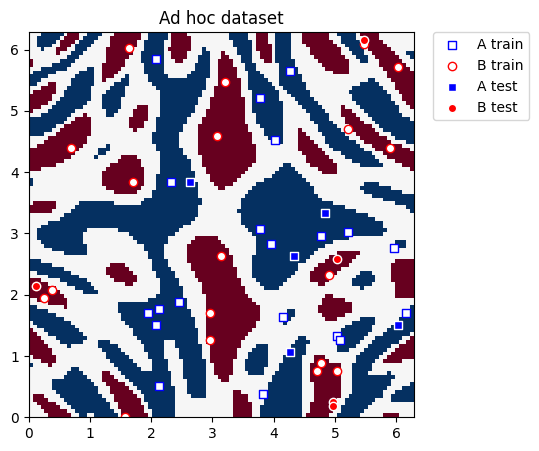

In [3]:


def plot_features(ax, features, labels, class_label, marker, face, edge, label):
    # A train plot
    ax.scatter(
        # x coordinate of labels where class is class_label
        features[np.where(labels[:] == class_label), 0],
        # y coordinate of labels where class is class_label
        features[np.where(labels[:] == class_label), 1],
        marker=marker,
        facecolors=face,
        edgecolors=edge,
        label=label,
    )


def plot_dataset(train_features, train_labels, test_features, test_labels, adhoc_total):

    plt.figure(figsize=(5, 5))
    plt.ylim(0, 2 * np.pi)
    plt.xlim(0, 2 * np.pi)
    plt.imshow(
        np.asmatrix(adhoc_total).T,
        interpolation="nearest",
        origin="lower",
        cmap="RdBu",
        extent=[0, 2 * np.pi, 0, 2 * np.pi],
    )

    # A train plot
    plot_features(plt, train_features, train_labels, 0, "s", "w", "b", "A train")

    # B train plot
    plot_features(plt, train_features, train_labels, 1, "o", "w", "r", "B train")

    # A test plot
    plot_features(plt, test_features, test_labels, 0, "s", "b", "w", "A test")

    # B test plot
    plot_features(plt, test_features, test_labels, 1, "o", "r", "w", "B test")

    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.0)
    plt.title("Ad hoc dataset")

    plt.show()
plot_dataset(train_features, train_labels, test_features, test_labels, adhoc_total)



This code sets up a quantum kernel for machine learning using Qiskit's quantum feature maps and fidelity-based kernel methods. The objective is to create a quantum feature map, define a fidelity-based quantum kernel, and visualize the feature map.

### Library Imports:
The script first imports necessary modules:
- `ZZFeatureMap`, `ZFeatureMap`, `RealAmplitudes`, and `PauliFeatureMap` from `qiskit.circuit.library` to define quantum feature maps.
- `StatevectorSampler` (renamed as `Sampler`) from `qiskit.primitives` to simulate quantum circuits and measure state vectors.
- `ComputeUncompute` from `qiskit_machine_learning.state_fidelities` to compute fidelity between quantum states.
- `FidelityQuantumKernel` from `qiskit_machine_learning.kernels`, which enables kernel-based quantum machine learning.

### Quantum Feature Map:
```python
adhoc_feature_map = ZZFeatureMap(feature_dimension=adhoc_dimension, reps=2, entanglement="linear")


### 1. **ZZFeatureMap**  
The `ZZFeatureMap` is a quantum feature map that uses `ZZ` gates to create quantum entanglement between qubits, allowing it to represent data features in a higher-dimensional quantum space. This feature map is useful when modeling complex relationships between data features, as quantum interactions between qubits can capture nonlinear patterns that would be difficult to identify using classical methods. It is typically used with a quantum kernel, such as the `FidelityQuantumKernel`, to measure the similarity between quantum states generated by the input data.


ZZFeatureMap


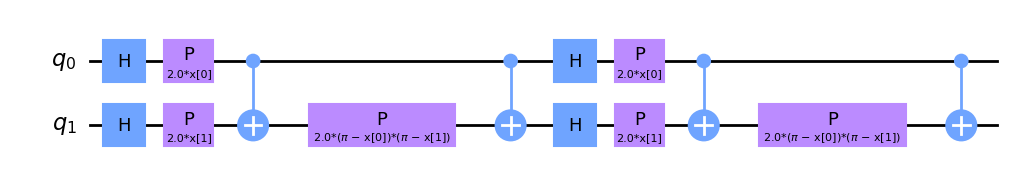

In [4]:

# ZZFeatureMap
print('ZZFeatureMap')
adhoc_feature_map = ZZFeatureMap(feature_dimension=adhoc_dimension, reps=2, entanglement="linear")
sampler = Sampler()
fidelity = ComputeUncompute(sampler=sampler)
adhoc_kernel = FidelityQuantumKernel(fidelity=fidelity, feature_map=adhoc_feature_map)
display(adhoc_feature_map.decompose().draw(output="mpl", style="clifford", fold=20))

### 2. **ZFeatureMap**  
The `ZFeatureMap` is another type of quantum feature map, but instead of using `ZZ` gates to generate entanglement between qubits, it uses `Z` gates that affect each qubit individually. This feature map is simpler than the `ZZFeatureMap` and generates a more direct and less complex quantum representation of the data. While its ability to model interactions between features is more limited than the `ZZFeatureMap`, it is still useful for representing data and providing more complexity in the quantum space compared to classical methods.


ZFeatureMap


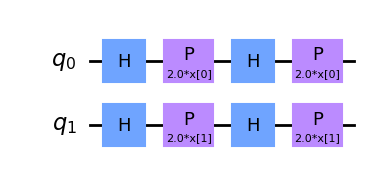

In [5]:
# ZFeatureMap
print('ZFeatureMap')
adhoc_feature_map_z = ZFeatureMap(feature_dimension=adhoc_dimension, reps=2)
sampler = Sampler()
fidelity_z = ComputeUncompute(sampler=sampler)
adhoc_kernel_z = FidelityQuantumKernel(fidelity=fidelity_z, feature_map=adhoc_feature_map_z)
display(adhoc_feature_map_z.decompose().draw(output="mpl", style="clifford", fold=20))

### 3. **RealAmplitudes Feature Map**  
The `RealAmplitudes` is a more complex quantum feature map that uses rotations on all qubits, allowing for a richer and more flexible quantum representation of the input data. Unlike the other feature maps, `RealAmplitudes` encodes data features into the amplitudes of quantum states, giving it a superior ability to represent complex patterns in the data. This feature map is ideal for tasks where a higher level of complexity in the quantum representation is desired and is especially useful when working with large volumes of data or highly nonlinear relationships.

RealAmplitudes


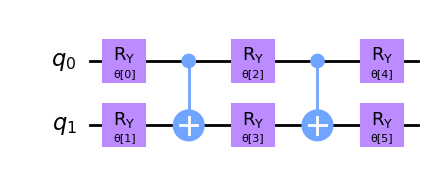

In [6]:
# RealAmplitudes Feature Map
# Use the number of qubits directly for RealAmplitudes
print('RealAmplitudes')
adhoc_feature_map_real = RealAmplitudes(adhoc_dimension, reps=2)
sampler = Sampler()
fidelity_real = ComputeUncompute(sampler=sampler)
adhoc_kernel_real = FidelityQuantumKernel(fidelity=fidelity_real, feature_map=adhoc_feature_map_real)
display(adhoc_feature_map_real.decompose().draw(output="mpl", style="clifford", fold=20))

### Explanation of the Code

The code uses a **Support Vector Classifier (SVC)** from the `sklearn.svm` module to train a machine learning model using a quantum kernel, specifically the `adhoc_kernel`.

1. **SVC initialization**  
   The `SVC` model is initialized with a **quantum kernel**. The `adhoc_kernel.evaluate` is used as the kernel for the classifier. In this case, `adhoc_kernel` is a quantum kernel based on the `FidelityQuantumKernel` and the chosen feature map, such as `ZZFeatureMap`, which defines how the quantum data is mapped. The `evaluate` method is passed to `SVC`, allowing it to compute the kernel values during training. This means that the classifier will use the quantum kernel's similarity measure instead of a classical kernel.

2. **Fitting the model**  
   The `fit` method is then called on the `adhoc_svc` object, which takes the **training data** (`train_features` and `train_labels`) to train the classifier. This process learns the optimal decision boundary for classifying the data based on the kernel's computation.

3. **Evaluating the model**  
   Once the model is trained, the `score` method is used on the `adhoc_svc` object to evaluate the model's performance on the **test data** (`test_features` and `test_labels`). This returns the classification accuracy, which is the percentage of correctly classified test samples.

4. **Output**  
   Finally, the test score (accuracy) is printed to the console. This value indicates how well the classifier performed using the quantum kernel to classify unseen data.

In summary, the code demonstrates how a **quantum kernel** can be integrated into a classical machine learning model (SVC) to perform classification tasks. The quantum kernel provides a similarity measure between quantum states, and the SVC uses this to separate the data in a higher-dimensional feature space.


In [7]:
adhoc_svc = SVC(kernel=adhoc_kernel.evaluate)
adhoc_svc.fit(train_features, train_labels)
adhoc_score_callable_function = adhoc_svc.score(test_features, test_labels)
print(f"Callable kernel classification test score: {adhoc_score_callable_function}")

Callable kernel classification test score: 1.0


### Explanation of the Code

This code computes and visualizes **kernel matrices** using the quantum kernel (`adhoc_kernel`) for both training and testing data. Here's what each part does:

1. **Kernel Matrix Calculation for Training Data**  
   The line `adhoc_matrix_train = adhoc_kernel.evaluate(x_vec=train_features)` computes the **kernel matrix** for the training data.  
   - The `evaluate` method of the `adhoc_kernel` calculates the kernel values (i.e., the pairwise similarities) between the **training samples** (`train_features`). 
   - The result is a **kernel matrix** where each entry represents the similarity between two training samples based on the quantum kernel's evaluation. Higher values in the matrix indicate higher similarity between those two samples.

2. **Kernel Matrix Calculation for Testing Data**  
   Similarly, the line `adhoc_matrix_test = adhoc_kernel.evaluate(x_vec=test_features, y_vec=train_features)` computes the kernel matrix for the **test data** compared with the **training data**.  
   - Here, the `evaluate` method is used with two inputs: `test_features` (the test data) and `train_features` (the training data). This results in a matrix where each entry represents the similarity between a test sample and a training sample.
   - The resulting matrix reflects how well the test data aligns with the trained model in the quantum feature space.

3. **Plotting the Kernel Matrices**  
   The code then visualizes both kernel matrices using **matplotlib** in two subplots.  
   - The `imshow` function is used to display both matrices as images. The `np.asmatrix` ensures that the kernel matrices are treated as matrices for proper visualization.
   - The first subplot (`axs[0]`) displays the **training kernel matrix** using a **blue colormap** (`Blues`), representing the similarities between the training samples.
   - The second subplot (`axs[1]`) displays the **testing kernel matrix** using a **red colormap** (`Reds`), representing the similarities between the test samples and the training data.

4. **Visual Output**  
   The result is two heatmaps:  
   - The **training kernel matrix** shows the pairwise similarities between training samples.
   - The **testing kernel matrix** shows how the test samples relate to the training samples, which can help to assess how well the model generalizes to unseen data.


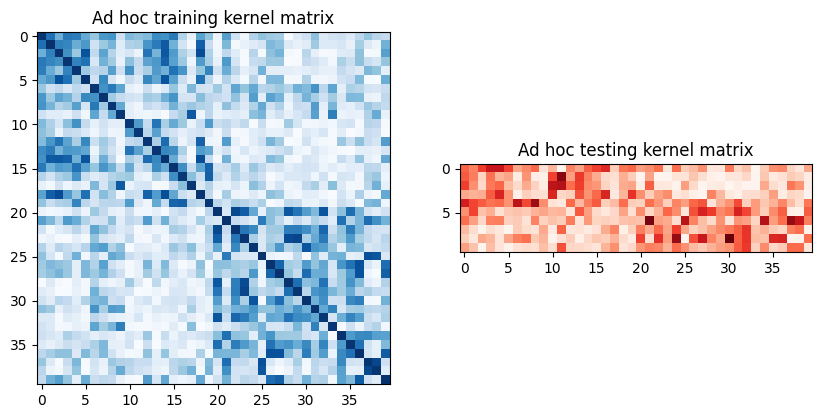

In [8]:
adhoc_matrix_train = adhoc_kernel.evaluate(x_vec=train_features)
adhoc_matrix_test = adhoc_kernel.evaluate(x_vec=test_features, y_vec=train_features)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(
    np.asmatrix(adhoc_matrix_train), interpolation="nearest", origin="upper", cmap="Blues"
)
axs[0].set_title("Ad hoc training kernel matrix")

axs[1].imshow(np.asmatrix(adhoc_matrix_test), interpolation="nearest", origin="upper", cmap="Reds")
axs[1].set_title("Ad hoc testing kernel matrix")

plt.show()

### Explanation of the Code

This code demonstrates how to use a **precomputed kernel matrix** with the **Support Vector Classifier (SVC)** to classify data. Here's what each part does:

1. **SVC Initialization with Precomputed Kernel**  
   The line `adhoc_svc = SVC(kernel="precomputed")` initializes the **SVC** model with a **precomputed kernel**.  
   - By setting `kernel="precomputed"`, we tell the `SVC` that instead of using a classical or quantum kernel function, we will directly provide a **kernel matrix** to the classifier. This matrix represents the pairwise similarities between samples, and the SVC will use this matrix to train and classify data.

2. **Training the Model with the Precomputed Kernel Matrix**  
   The line `adhoc_svc.fit(adhoc_matrix_train, train_labels)` trains the SVC classifier using the **precomputed kernel matrix** for the training data (`adhoc_matrix_train`) and the corresponding **training labels** (`train_labels`).  
   - The `adhoc_matrix_train` is the kernel matrix computed earlier using the quantum kernel, where each entry indicates the similarity between a pair of training samples.
   - The SVC uses this kernel matrix to learn the decision boundary that separates different classes in the training data.

3. **Evaluating the Model with the Precomputed Kernel**  
   After training, the model is evaluated using the kernel matrix for the test data (`adhoc_matrix_test`) with the line `adhoc_score_precomputed_kernel = adhoc_svc.score(adhoc_matrix_test, test_labels)`.  
   - The `adhoc_matrix_test` is the kernel matrix computed for the test data in relation to the training data.
   - The `score` method calculates the accuracy of the classifier by comparing the predicted labels (based on the kernel similarities) with the true test labels (`test_labels`).

4. **Output**  
   Finally, the test score (classification accuracy) is printed to the console:  
   `print(f"Precomputed kernel classification test score: {adhoc_score_precomputed_kernel}")`
   - This output shows how well the SVC classifier, using the precomputed quantum kernel matrix, performed on the test data.

In summary, the code demonstrates how to use a precomputed kernel matrix (which contains pairwise similarity values) to train and test an SVC classifier. This method leverages the quantum kernel's ability to calculate complex similarities between data points without explicitly defining a feature mapping function.


In [9]:
adhoc_svc = SVC(kernel="precomputed")
adhoc_svc.fit(adhoc_matrix_train, train_labels)
adhoc_score_precomputed_kernel = adhoc_svc.score(adhoc_matrix_test, test_labels)
print(f"Precomputed kernel classification test score: {adhoc_score_precomputed_kernel}")

Precomputed kernel classification test score: 1.0


### Explanation of the Code

This code demonstrates how to use the **Quantum Support Vector Classifier (QSVC)** with a quantum kernel to classify data. Here's what each part does:

1. **QSVC Initialization with Quantum Kernel**  
   The line `qsvc = QSVC(quantum_kernel=adhoc_kernel)` initializes the **Quantum Support Vector Classifier (QSVC)** with a **quantum kernel** (`adhoc_kernel`).  
   - Unlike the classical Support Vector Machine (SVM), the QSVC uses a **quantum kernel** to compute the similarity between data points. In this case, the `adhoc_kernel` is a quantum kernel (such as a FidelityQuantumKernel) defined earlier in the code.

2. **Training the QSVC Model**  
   The line `qsvc.fit(train_features, train_labels)` trains the QSVC classifier on the **training data** (`train_features`) and their corresponding **labels** (`train_labels`).  
   - The QSVC uses the quantum kernel (`adhoc_kernel`) to calculate pairwise similarities between training samples in a quantum feature space.
   - It then learns the optimal hyperplane in this quantum space to classify the data based on the provided training labels.

3. **Evaluating the QSVC Model**  
   The line `qsvc_score = qsvc.score(test_features, test_labels)` evaluates the performance of the trained QSVC model on the **test data** (`test_features`) and the true **test labels** (`test_labels`).  
   - The `score` method calculates the classification accuracy, which is the percentage of test samples that were correctly classified based on the learned quantum kernel.

4. **Output**  
   Finally, the classification test score (accuracy) is printed with the line:  
   `print(f"QSVC classification test score: {qsvc_score}")`  
   - This output shows how well the **Quantum Support Vector Classifier** performed on the test dataset using the quantum kernel to compute pairwise similarities.

In summary, this code demonstrates how to train and evaluate a **Quantum Support Vector Classifier (QSVC)** using a quantum kernel. The QSVC is an extension of the classical SVC but uses quantum computing to compute similarities in a quantum feature space, potentially enabling better generalization and handling of complex data patterns.


In [10]:

qsvc = QSVC(quantum_kernel=adhoc_kernel)

qsvc.fit(train_features, train_labels)

qsvc_score = qsvc.score(test_features, test_labels)

print(f"QSVC classification test score: {qsvc_score}")

QSVC classification test score: 1.0


### Comparison of Different Classification Models and Their Accuracy Scores

1. **SVC using Kernel as a Callable Function**:
   In this implementation, the **Support Vector Classifier (SVC)** uses a kernel that is passed as a callable function (`adhoc_kernel.evaluate`). This means that the kernel is evaluated dynamically during each training iteration, allowing the model to compute pairwise similarities on-the-fly. This approach is useful when the kernel needs to be customized or computed at each step. However, it can be computationally expensive because the kernel is recalculated for each pair of data points during training.

2. **SVC using Precomputed Kernel Matrix**:
   The **SVC using precomputed kernel matrix** approach involves computing the kernel matrix once before training, which contains all pairwise similarity values between data points. This precomputed matrix is then provided to the SVC for training and testing, which eliminates the need to evaluate the kernel during training. This method is computationally more efficient during training because the kernel values are already available, but it requires the kernel to be computed in advance.

3. **QSVC (Quantum Support Vector Classifier)**:
   The **Quantum Support Vector Classifier (QSVC)** uses a quantum kernel to calculate the pairwise similarities between data points. This quantum kernel is computed using quantum circuits, which map data points to high-dimensional quantum feature spaces. The quantum approach allows QSVC to explore complex feature mappings that may be difficult to handle with classical methods, potentially offering improved performance for more challenging datasets. However, this method requires access to quantum computing resources or simulators.


In [11]:
print(f"Classification Model                    | Accuracy Score")
print(f"---------------------------------------------------------")
print(f"SVC using kernel as a callable function | {adhoc_score_callable_function:10.2f}")
print(f"SVC using precomputed kernel matrix     | {adhoc_score_precomputed_kernel:10.2f}")
print(f"QSVC                                    | {qsvc_score:10.2f}")

Classification Model                    | Accuracy Score
---------------------------------------------------------
SVC using kernel as a callable function |       1.00
SVC using precomputed kernel matrix     |       1.00
QSVC                                    |       1.00
